# Data Science

- Student: Dmytro Geleshko
- Group: IP-91
- Var: 6

## Imports

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Config

In [64]:
# var 6
np.random.seed(6)
plt.rcParams["figure.figsize"] = (20, 8)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.3f}".format

## Functions

In [65]:
def lsm_create_f(size, pol_pow):
    """
    Creating F matrix:
    1, x, x^2, ..., x^PARAM_max_pow
    """
    
    F = np.ones((size, pol_pow + 1))
    for i in range(1, pol_pow + 1):
        # pow
        F[:, i] = np.power(np.arange(0, size), i)
    return F


def lsm_coef(y, F):
    """
    Returns matrix of coef. C.
    """

    # 1-d array to row vector
    Y = y.reshape(-1, 1)
    # calc
    FT = F.T
    FF = np.dot(FT, F)
    FFI = np.linalg.inv(FF)
    FFIFT = np.dot(FFI, FT)
    # return coef
    return np.dot(FFIFT, Y)

# Data

## Load And Format Data

In [68]:
df = pd.read_excel("Data_Set_6.xlsx", index_col=[0, 1], thousands=",")

# replace missing values
df.replace("not avilable", np.NaN, inplace=True)
df.replace("n.a.", np.NaN, inplace=True)
df.replace(-1, np.NaN, inplace=True)

# lower the names of columns and indexes
df.columns = [name.lower() for name in df.columns]
df.index.set_names([name.lower() for name in df.index.names], inplace=True)


# sort by sale_id
df.sort_index(inplace=True)
df

january  february     march     april   may  \
sales_id sales_by_region                                                 
1        AUH             3,469.000       NaN       NaN 3,642.000  5803   
         SHJ             5,840.000 5,270.000 4,114.000 5,605.000  4387   
         UAQ             2,967.000 2,425.000 5,353.000 3,547.000  5027   
2        AUH             1,328.000 4,264.000 1,574.000 2,343.000  3826   
3        AUH             1,722.000   956.000 1,297.000 1,984.000  2744   
...                            ...       ...       ...       ...   ...   
29       UAQ             5,325.000 1,905.000 5,049.000 1,311.000  4146   
30        FUJ            3,402.000 5,283.000 2,229.000 3,758.000  1427   
          FUJ            5,549.000 1,302.000 1,929.000 2,822.000  5379   
         AJM             2,832.000 5,978.000 1,684.000 1,550.000  1194   
         AJM             2,028.000 2,006.000 5,120.000 5,959.000  3127   

                              june      july    august  september   october  \
sales_id sales_by_region                                                      
1        AUH             5,662.000 1,896.000 2,293.000       2583 5,233.000   
         SHJ             5,026.000 4,055.000 2,782.000       4578 4,993.000   
         UAQ             4,078.000 3,858.000 1,927.000       3527 4,179.000   
2        AUH             4,932.000 1,710.000 3,221.000       3381 1,313.000   
3        AUH             5,793.000 2,261.000 5,607.000       2437 4,328.000   
...                            ...       ...       ...        ...       ...   
29       UAQ             1,706.000 1,689.000 3,190.000       2915 2,183.000   
30        FUJ            1,057.000 5,277.000 5,231.000       3909 4,345.000   
          FUJ            1,243.000 3,075.000 4,358.000       5106 2,322.000   
         AJM             3,737.000 5,779.000 4,441.000       1213 3,711.000   
         AJM             3,962.000 4,780.000 3,200.000       1836 2,623.000   

                          november  december  
sales_id sales_by_region                      
1        AUH                  4421 4,071.000  
         SHJ                  2859 4,853.000  
         UAQ                  1571 5,551.000  
2        AUH                  1765 1,214.000  
3        AUH                  3317 5,390.000  
...                            ...       ...  
29       UAQ                  3301 4,365.000  
30        FUJ                 5287 2,638.000  
          FUJ                 2409 1,069.000  
         AJM                  5384 1,293.000  
         AJM                  1607 2,371.000  

[98 rows x 12 columns]

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 98 entries, (1, 'AUH') to (30, 'AJM')
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   january    92 non-null     float64
 1   february   96 non-null     float64
 2   march      95 non-null     float64
 3   april      97 non-null     float64
 4   may        98 non-null     int64  
 5   june       95 non-null     float64
 6   july       97 non-null     float64
 7   august     96 non-null     float64
 8   september  98 non-null     int64  
 9   october    97 non-null     float64
 10  november   98 non-null     int64  
 11  december   96 non-null     float64
dtypes: float64(9), int64(3)
memory usage: 11.1+ KB


## Fill NaN

In [70]:
df = df.ffill(axis=1).bfill(axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 98 entries, (1, 'AUH') to (30, 'AJM')
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   january    98 non-null     float64
 1   february   98 non-null     float64
 2   march      98 non-null     float64
 3   april      98 non-null     float64
 4   may        98 non-null     float64
 5   june       98 non-null     float64
 6   july       98 non-null     float64
 7   august     98 non-null     float64
 8   september  98 non-null     float64
 9   october    98 non-null     float64
 10  november   98 non-null     float64
 11  december   98 non-null     float64
dtypes: float64(12)
memory usage: 11.1+ KB


## Cast to np.float32

In [71]:
df[df.columns] = df[df.columns].values.astype(np.float32)
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 98 entries, (1, 'AUH') to (30, 'AJM')
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   january    98 non-null     float32
 1   february   98 non-null     float32
 2   march      98 non-null     float32
 3   april      98 non-null     float32
 4   may        98 non-null     float32
 5   june       98 non-null     float32
 6   july       98 non-null     float32
 7   august     98 non-null     float32
 8   september  98 non-null     float32
 9   october    98 non-null     float32
 10  november   98 non-null     float32
 11  december   98 non-null     float32
dtypes: float32(12)
memory usage: 6.5+ KB


## Drop Unnecessary Index, Aggregate, Transpose

In [72]:
df = df.reset_index(level=[0]).drop(columns="sales_id").groupby(level=0).sum().T
df

sales_by_region,FUJ,AJM,AUH,DXB,RAK,SHJ,UAQ
january,"48,027.000","70,596.000","44,095.000","44,855.000","35,430.000","49,216.000","38,536.000"
february,"49,784.000","72,046.000","35,729.000","46,403.000","29,675.000","49,905.000","27,907.000"
march,"51,818.000","65,340.000","42,978.000","49,342.000","30,253.000","45,713.000","30,812.000"
april,"54,488.000","71,625.000","54,463.000","58,802.000","31,509.000","45,500.000","32,170.000"
may,"54,609.000","76,144.000","45,860.000","54,559.000","29,133.000","46,793.000","31,776.000"
june,"51,726.000","66,574.000","65,801.000","55,884.000","28,853.000","50,826.000","34,040.000"
july,"46,631.000","73,787.000","38,836.000","51,674.000","25,918.000","48,329.000","25,279.000"
august,"48,243.000","67,747.000","45,544.000","42,659.000","31,480.000","45,693.000","31,140.000"
september,"49,037.000","63,977.000","49,261.000","56,462.000","18,834.000","49,373.000","29,645.000"
october,"47,963.000","84,601.000","39,233.000","50,892.000","18,337.000","53,990.000","28,376.000"


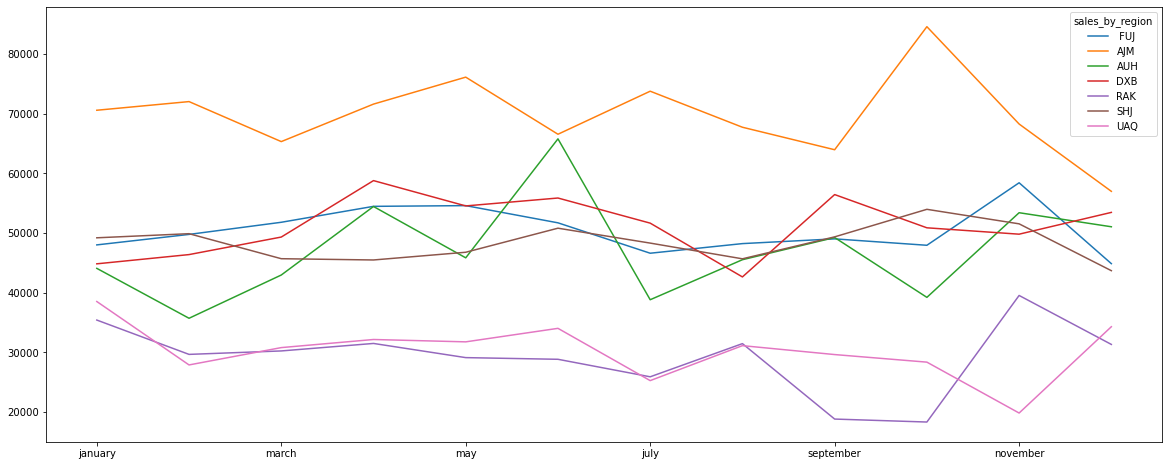

In [87]:
df.plot()
plt.show()

From this chart we can see that simple linear regression (y = ax + b) will be able to fit to data

# LSM For Each Region

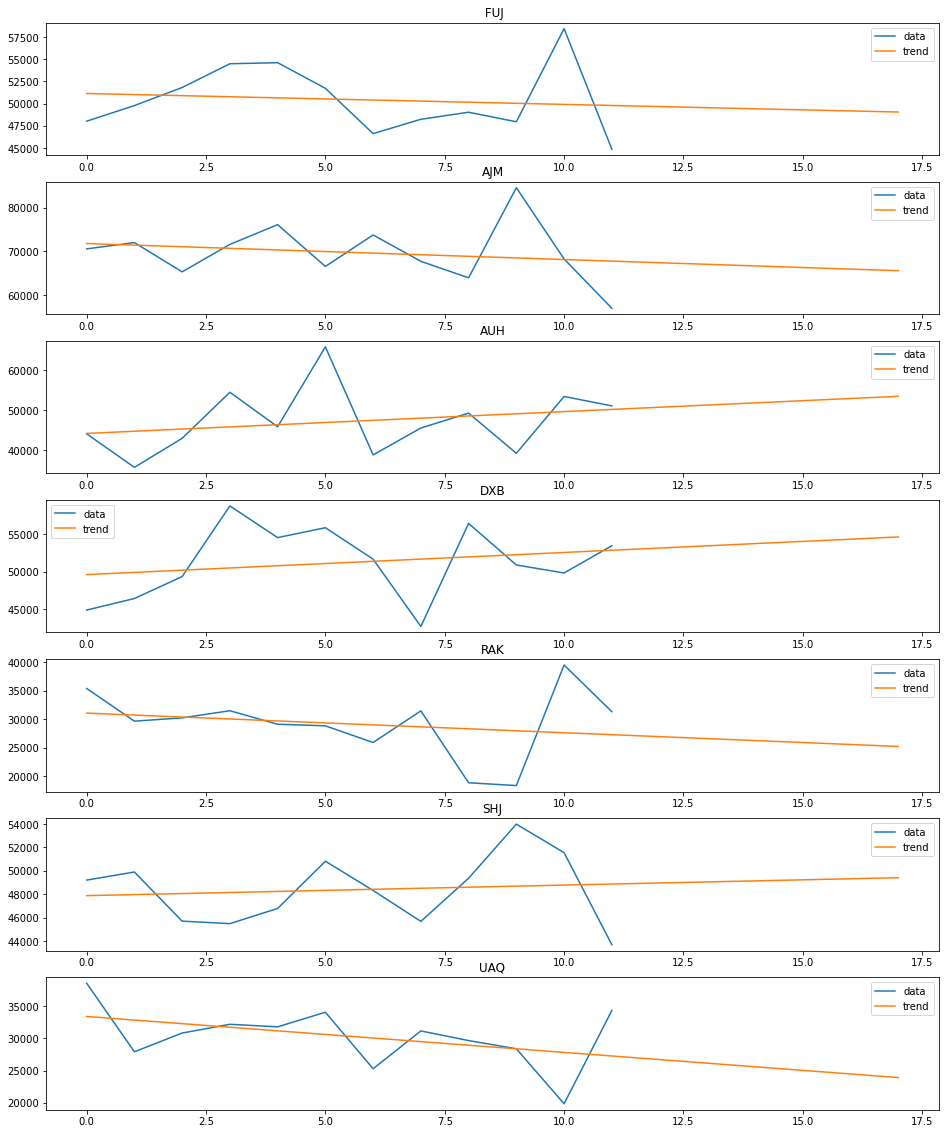

In [96]:
plt.rcParams["figure.figsize"] = (16, 20)
fig, axes = plt.subplots(df.columns.shape[0], 1)

for i, region in enumerate(df.columns):
    y = df[region].values

    # find C
    F = lsm_create_f(y.shape[0], 1)
    C = lsm_coef(y, F)

    # forecast
    F = lsm_create_f(y.shape[0] + 6, 1)
    y_hat = np.dot(F, C).reshape(-1)

    #plot
    axes[i].plot(np.arange(y.shape[0]), y, label="data")
    axes[i].plot(np.arange(y_hat.shape[0]), y_hat, label="trend")
    axes[i].set_title(region)
    axes[i].legend()

plt.show()